<a href="https://colab.research.google.com/github/CryptoSalamander/pytorch_paper_implementation/blob/master/resnet/resnet_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# from torchvision.datasets import ImageNet


In [2]:
# import os

# %cd "/content/drive/MyDrive/AISystemDesign2024"

# # 현재 작업 디렉토리 확인
# current_directory = os.getcwd()

# # 출력
# print(f"현재 작업 디렉토리: {current_directory}")
# %ls

In [3]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
#from resnet import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
import os
import torchvision.models as models
import torchvision.models as models


In [4]:
# # Simple Learning Rate Scheduler
# def lr_scheduler(optimizer, epoch):
#     lr = learning_rate
#     if epoch >= 50:
#         lr /= 10
#     if epoch >= 100:
#         lr /= 10
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr

# # Xavier
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.xavier_uniform(m.weight)
#         m.bias.data.fill_(0.01)

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=8)

100%|██████████| 170M/170M [00:16<00:00, 10.5MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# 장치 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 가능한 장치: {device}")

model = models.resnet50(pretrained=True)
model = model.to(device)

# ResNet18, ResNet34, ResNet50, ResNet101, ResNet152 중에 택일하여 사용

사용 가능한 장치: cuda


/home/ondevice/.conda/envs/ondevice/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ondevice/.conda/envs/ondevice/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/ondevice/.conda/envs/ondevice/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [7]:
# model.apply(init_weights)
# model = model.to(device)

In [8]:
learning_rate = 0.1
num_epoch = 150
model_name = 'model.pth'

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

train_loss = 0
valid_loss = 0
correct = 0
total_cnt = 0
best_acc = 0

In [9]:
# Train
for epoch in range(num_epoch):
    print(f"====== { epoch+1} epoch of { num_epoch } ======")
    model.train()
    lr_scheduler(optimizer, epoch)
    train_loss = 0
    valid_loss = 0
    correct = 0
    total_cnt = 0
    # Train Phase
    for step, batch in enumerate(train_loader):
        #  input and target
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()

        logits = model(batch[0])
        loss = loss_fn(logits, batch[1])
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predict = logits.max(1)

        total_cnt += batch[1].size(0)
        correct +=  predict.eq(batch[1]).sum().item()

        if step % 100 == 0 and step != 0:
            print(f"\n====== { step } Step of { len(train_loader) } ======")
            print(f"Train Acc : { correct / total_cnt }")
            print(f"Train Loss : { loss.item() / batch[1].size(0) }")

    correct = 0
    total_cnt = 0

# Test Phase
    with torch.no_grad():
        model.eval()
        for step, batch in enumerate(test_loader):
            # input and target
            batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
            total_cnt += batch[1].size(0)
            logits = model(batch[0])
            valid_loss += loss_fn(logits, batch[1])
            _, predict = logits.max(1)
            correct += predict.eq(batch[1]).sum().item()
        valid_acc = correct / total_cnt
        print(f"\nValid Acc : { valid_acc }")
        print(f"Valid Loss : { valid_loss / total_cnt }")

        if(valid_acc > best_acc):
            best_acc = valid_acc
            torch.save(model, model_name)
            print("Model Saved!")

====== 1 epoch of 150 ======


NameError: name 'lr_scheduler' is not defined

# Resnet-50 모델 구조







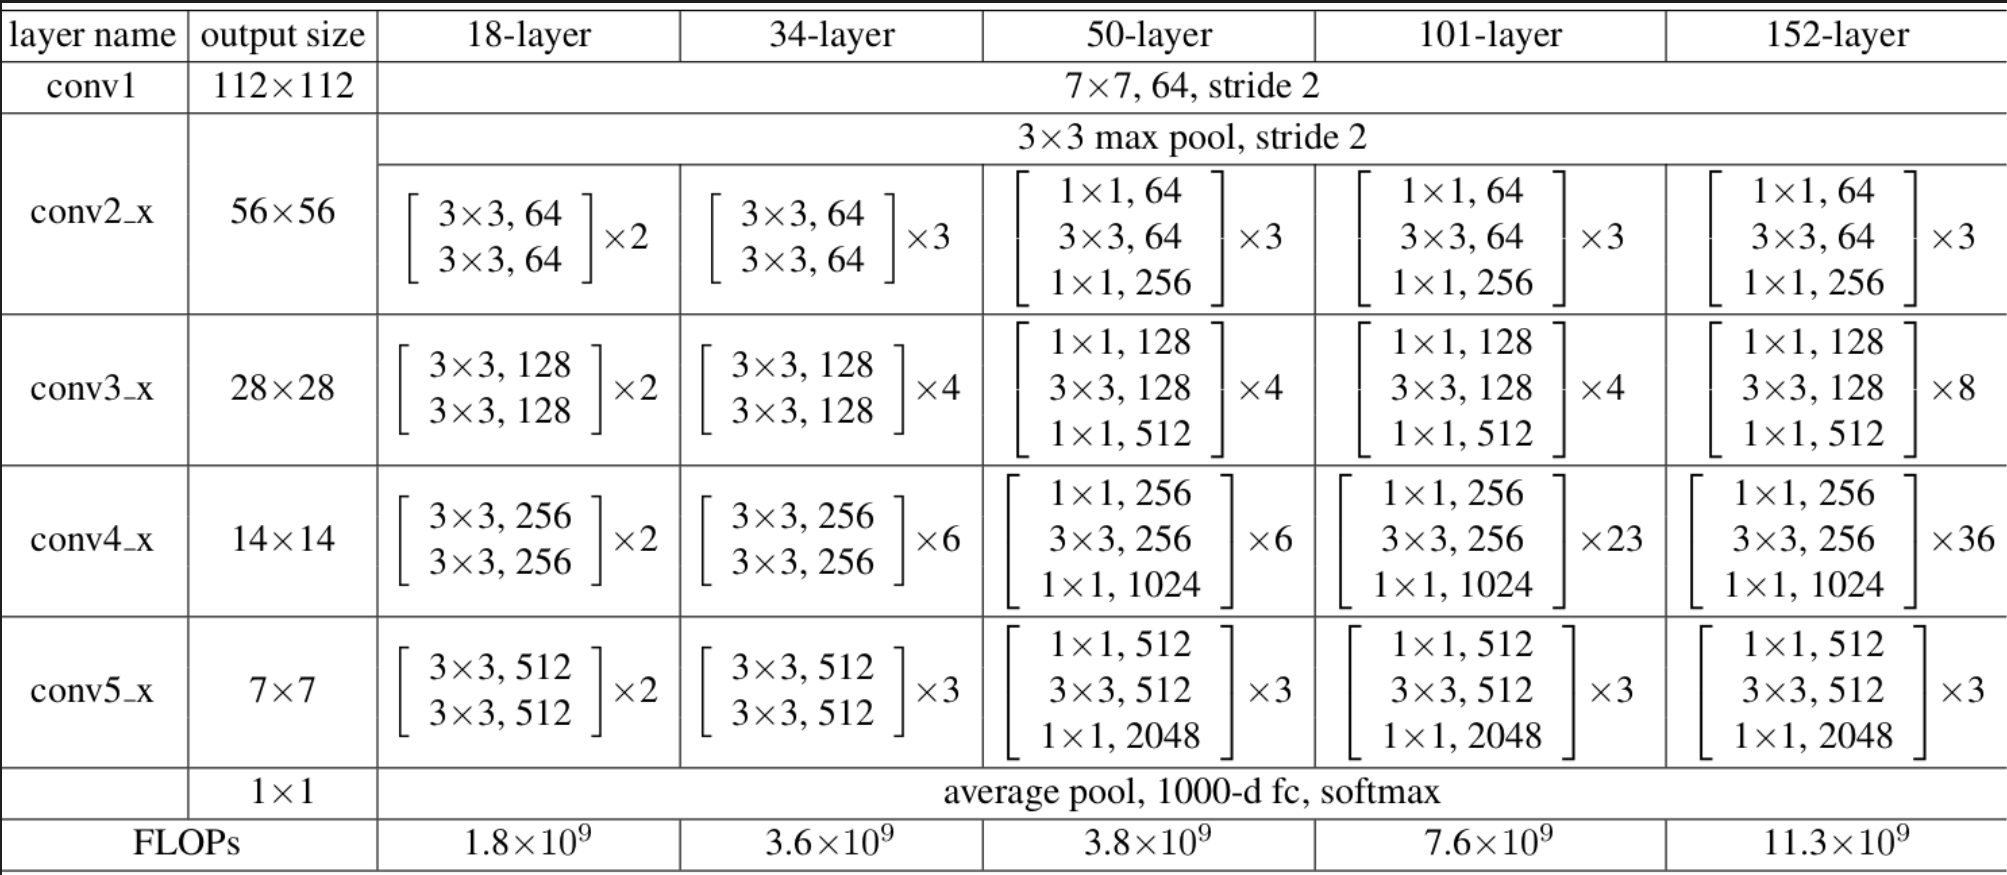

# Resnet-50 layer별 qint8 Activation 및 Kernel값의 0값 비율에 대한 통계

In [ ]:
# 레이터별 Activation과 kernel 값 중에 0값 비율 확인
#checkpoint = torch.load(model_name)
#model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

# Hook 함수 정의
activation_values = {}
kernel_values = {}
total_zero_activation_ratios = {}
total_zero_kernel_ratios = {}

def get_activation(name):
    def hook(model, input, output):
        quantized_output = torch.quantize_per_tensor(output, scale=1.0, zero_point=0, dtype=torch.qint8)
        activation_values[name] = quantized_output.detach()
    return hook

def get_kernel(name):
    def hook(model, input, output):
        quantized_kernel = torch.quantize_per_tensor(model.weight.data, scale=1.0, zero_point=0, dtype=torch.qint8)
        kernel_values[name] = quantized_kernel
    return hook

# Hook 등록
for name, layer in model.named_modules():
    if isinstance(layer, (nn.Linear, nn.Conv2d)):
        layer.register_forward_hook(get_activation(name))
        layer.register_forward_hook(get_kernel(name))

# 예제 데이터 입력
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

with torch.no_grad():
    model.eval()
    for step, batch in enumerate(test_loader):
        # 매 iteration마다 activation_values와 kernel_values 초기화
        activation_values = {}
        kernel_values = {}

        # input and target
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        total_cnt += batch[1].size(0)
        logits = model(batch[0])
        _, predict = logits.max(1)
        correct += predict.eq(batch[1]).sum().item()

        for name, activation in activation_values.items():
            activation_f32 = torch.dequantize(activation)
            zero_ratio = (activation_f32 == 0).sum().item() / activation_f32.numel()
            total_zero_activation_ratios.setdefault(name, []).append(zero_ratio)

        for name, kernel in kernel_values.items():
            kernel_f32 = torch.dequantize(kernel)
            zero_ratio = (kernel_f32 == 0).sum().item() / kernel_f32.numel()
            total_zero_kernel_ratios.setdefault(name, []).append(zero_ratio)

    valid_acc = correct / total_cnt
    print(f"\nValid Acc : { valid_acc }")

for name in total_zero_activation_ratios:
    avg_activation_zero_ratio = sum(total_zero_activation_ratios[name]) / len(total_zero_activation_ratios[name])
    avg_kernel_zero_ratio = sum(total_zero_kernel_ratios[name]) / len(total_zero_kernel_ratios[name])
    print(f"Layer: {name}, Avg Activation 0 ratio: {avg_activation_zero_ratio:.4f}, Avg Kernel 0 ratio: {avg_kernel_zero_ratio:.4f}")


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data = [
    {"Layer": "conv1", "Avg Activation 0 ratio": 0.0369, "Avg Kernel 0 ratio": 0.3969},
    {"Layer": "layer1.0.conv1", "Avg Activation 0 ratio": 0.0158, "Avg Kernel 0 ratio": 0.5959},
    {"Layer": "layer1.0.conv2", "Avg Activation 0 ratio": 0.0092, "Avg Kernel 0 ratio": 0.6588},
    {"Layer": "layer1.0.conv3", "Avg Activation 0 ratio": 0.1642, "Avg Kernel 0 ratio": 0.9387},
    {"Layer": "layer1.0.shortcut.0", "Avg Activation 0 ratio": 0.0512, "Avg Kernel 0 ratio": 0.9436},
    {"Layer": "layer1.1.conv1", "Avg Activation 0 ratio": 0.0346, "Avg Kernel 0 ratio": 0.7704},
    {"Layer": "layer1.1.conv2", "Avg Activation 0 ratio": 0.0149, "Avg Kernel 0 ratio": 0.8285},
    {"Layer": "layer1.1.conv3", "Avg Activation 0 ratio": 0.1889, "Avg Kernel 0 ratio": 0.9680},
    {"Layer": "layer1.2.conv1", "Avg Activation 0 ratio": 0.0395, "Avg Kernel 0 ratio": 0.8979},
    {"Layer": "layer1.2.conv2", "Avg Activation 0 ratio": 0.0334, "Avg Kernel 0 ratio": 0.9530},
    {"Layer": "layer1.2.conv3", "Avg Activation 0 ratio": 0.3328, "Avg Kernel 0 ratio": 0.9930},
    {"Layer": "layer2.0.conv1", "Avg Activation 0 ratio": 0.0554, "Avg Kernel 0 ratio": 0.9946},
    {"Layer": "layer2.0.conv2", "Avg Activation 0 ratio": 0.0813, "Avg Kernel 0 ratio": 0.9990},
    {"Layer": "layer2.0.conv3", "Avg Activation 0 ratio": 0.7498, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer2.0.shortcut.0", "Avg Activation 0 ratio": 0.1369, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer2.1.conv1", "Avg Activation 0 ratio": 0.1819, "Avg Kernel 0 ratio": 0.9999},
    {"Layer": "layer2.1.conv2", "Avg Activation 0 ratio": 0.1644, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer2.1.conv3", "Avg Activation 0 ratio": 0.8164, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer2.2.conv1", "Avg Activation 0 ratio": 0.1961, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer2.2.conv2", "Avg Activation 0 ratio": 0.2757, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer2.2.conv3", "Avg Activation 0 ratio": 0.8908, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer2.3.conv1", "Avg Activation 0 ratio": 0.1657, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer2.3.conv2", "Avg Activation 0 ratio": 0.4367, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer2.3.conv3", "Avg Activation 0 ratio": 0.9049, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.0.conv1", "Avg Activation 0 ratio": 0.2472, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.0.conv2", "Avg Activation 0 ratio": 0.4372, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.0.conv3", "Avg Activation 0 ratio": 0.9278, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.0.shortcut.0", "Avg Activation 0 ratio": 0.4482, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.1.conv1", "Avg Activation 0 ratio": 0.3668, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.1.conv2", "Avg Activation 0 ratio": 0.4158, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.1.conv3", "Avg Activation 0 ratio": 0.9211, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.2.conv1", "Avg Activation 0 ratio": 0.2444, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.2.conv2", "Avg Activation 0 ratio": 0.4057, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.2.conv3", "Avg Activation 0 ratio": 0.9009, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.3.conv1", "Avg Activation 0 ratio": 0.1193, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.3.conv2", "Avg Activation 0 ratio": 0.4513, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.3.conv3", "Avg Activation 0 ratio": 0.9238, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.4.conv1", "Avg Activation 0 ratio": 0.1200, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.4.conv2", "Avg Activation 0 ratio": 0.4712, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.4.conv3", "Avg Activation 0 ratio": 0.9545, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.5.conv1", "Avg Activation 0 ratio": 0.1033, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.5.conv2", "Avg Activation 0 ratio": 0.5457, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer3.5.conv3", "Avg Activation 0 ratio": 0.9363, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer4.0.conv1", "Avg Activation 0 ratio": 0.0827, "Avg Kernel 0 ratio": 0.9991},
    {"Layer": "layer4.0.conv2", "Avg Activation 0 ratio": 0.6191, "Avg Kernel 0 ratio": 0.9999},
    {"Layer": "layer4.0.conv3", "Avg Activation 0 ratio": 0.8943, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer4.0.shortcut.0", "Avg Activation 0 ratio": 0.0973, "Avg Kernel 0 ratio": 0.9998},
    {"Layer": "layer4.1.conv1", "Avg Activation 0 ratio": 0.5914, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer4.1.conv2", "Avg Activation 0 ratio": 0.8529, "Avg Kernel 0 ratio": 0.9998},
    {"Layer": "layer4.1.conv3", "Avg Activation 0 ratio": 0.9748, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer4.2.conv1", "Avg Activation 0 ratio": 0.6346, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer4.2.conv2", "Avg Activation 0 ratio": 0.9595, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "layer4.2.conv3", "Avg Activation 0 ratio": 0.9867, "Avg Kernel 0 ratio": 1.0000},
    {"Layer": "linear", "Avg Activation 0 ratio": 0.0969, "Avg Kernel 0 ratio": 0.9990}]

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df["Layer"], df["Avg Activation 0 ratio"], label="Avg Activation 0 ratio", marker="o")
plt.plot(df["Layer"], df["Avg Kernel 0 ratio"], label="Avg Kernel 0 ratio", marker="x")

# Adding labels, title, and formatting
plt.xlabel("Layer", fontsize=12)
plt.ylabel("Zero-Ratio", fontsize=12)
plt.title("Activation vs Kernel Zero-Ratio per ResNet-50 Layer (cifar-10)", fontsize=14)
plt.xticks(rotation=90, fontsize=6)
plt.xticks(ticks=range(len(df["Layer"])), labels=df["Layer"], fontsize=8)
plt.ylim(0, 1)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()